# Investigating the GNU Octave mailing-list activity

> *Dec 17, 2019 — Kai T. Ohlhus &lt;<k.ohlhus@gmail.com>&gt; — [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/)*

This Jupyter-Octave-Notebook is inspired by the
[opening talk](https://indico.cern.ch/event/626097/contributions/2902420/attachments/1615292/2566811/2018-03-12-octave.pdf)
by John W. Eaton at the [OctConf 2018](https://wiki.octave.org/OctConf_2018)
at CERN in Geneva, Switzerland.
The outline is as follows:

1. [Crawl](https://en.wikipedia.org/wiki/Web_crawler) the Octave mailing-list
   archives at *gnu.org* to get the monthly number of emails.
2. Present the data graphically.
3. Show a correlation between peaks in the mailing-lists and Octave releases.

A selection of utilized functions and links to the Manual are given in the
[final section](#Final-remarks).

## Define the investigation parameters

In [1]:
base_url = "https://lists.gnu.org/archive/html";
lists    = {"help-octave", "octave-maintainers", "octave-bug-tracker"};
[this_year, ~] = datevec (now ());
years          = 1992:this_year;

## Getting data from gnu.org

Basically, the Octave mailing-list archives at *gnu.org* are only crawled on the
first run of this Notebook.
The results are cached in a file `mailing_list_activity.mat`.
Thus if the parameters above are changed,
the cache file is invalid and has to be deleted.
On a usual PC with moderate fast internet connection,
running this section for the first time takes about **25 minutes**
for $3 \times 28 \times 12 = 1008$ (partially unnecessary) web requests.
This makes about 0.67 requests per second and there is lots of potential for improvement,
which will not be addressed here.

According to the current implementation of the mailing-list archives,
a sequence of URLs
* https://lists.gnu.org/archive/html/help-octave/1993-01
* https://lists.gnu.org/archive/html/help-octave/1993-02
* ...

is generated.
The respective page source code is read into a string by `urlread`.
Finally, in that string an email is counted by finding starting HTML `<li>`- and `<a>`-tags.

In [2]:
data_file = "data/mailing_list_activity.mat";
if (exist (data_file, "file") == 2)
  load (data_file, "activity");     # Use cache if possible
else
  M = length (lists);
  N = length (years);
  activity = zeros (M, N * 12);
  tic;
  for i = 1:M           # For all mailing-lists
    list_url = sprintf ("%s/%s/", base_url, lists{i});
    for j = 1:N         # For each year
      for month = 1:12  # For each month
        tick = sprintf ("%d-%02d", years(j), month)
        try
          html = urlread ([list_url, tick]);
          activity(i, (j-1)*12 + month) = length (strfind (html, "<li><a"));
        catch
          printf ("  No data for %s.\n", tick);
        end_try_catch
      endfor
    endfor
  endfor
  elapsed_time = toc
  save (data_file, "activity");
endif

To get an idea of the data, one can easily display a portion of it.
Using the statement below, the data for **July to December** of the **current year** is shown.
The first row displays a numeric value for the month.
The second to last row show the number of emails of the respective mailing-lists
*help-octave@gnu.org*, *octave-maintainers@gnu.org*, and *octave-bug-tracker@gnu.org*.
Obviously, the data for December is not yet complete.

In [3]:
disp ([7:12; activity(:,end-5:end)])

     7     8     9    10    11    12
   171   178   143   296   257    48
    65    87    98   172    96    94
   372   341   429   649   858   444


## Present the data graphically

["A picture is worth a thousand words"](https://en.wikipedia.org/wiki/A_picture_is_worth_a_thousand_words).
This is often true in science, as well.
Presenting data graphically sometimes reveals patterns that are not obvious from the bare figures.
GNU Octave has many built-in functions to do this.
A bare minimum of necessary code to visualize the `activity`-matrix might be:

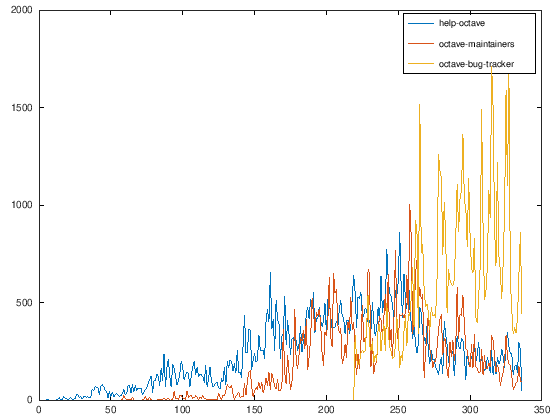

In [4]:
x_ticks = 1:size (activity, 2);
plot (x_ticks, activity(1,:), ...
      x_ticks, activity(2,:), ...
      x_ticks, activity(3,:))
legend (lists);

To tune the figure for a publication, the following modifications are performed:

1. Smoothing the graphs by applying a five-month
   [moving average](https://en.wikipedia.org/wiki/Moving_average).
   Note, that this operation also removes peak values, like `activity_max`.

In [5]:
activity_smooth = movmean (activity, 5, 2, "endpoints", "shrink");
activity_max    = max (max (activity))

activity_max =  1710


2. Creating a meaningful x-axis consisting of date values.
   This is done in combination with the `datetick("x")` function.

In [6]:
x_ticks = arrayfun (@(x,y) datenum(x, y, 01), ...
                           repelem(years, 12), ...
                           repmat(1:12, 1, length (years)));

3. Changing the graph colors,
   increasing the font sizes and line width,
   reposition the legend, and
   add verbose axis labels.

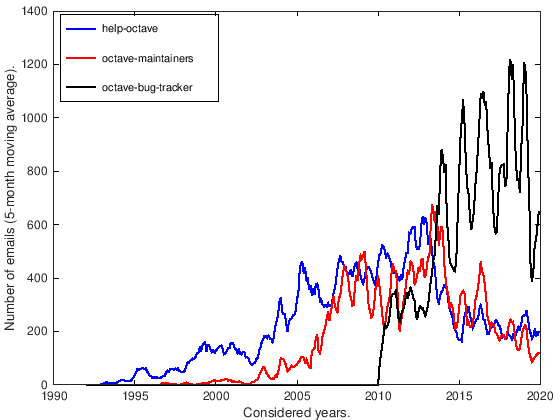

In [7]:
set (0, "DefaultLineLineWidth", 4);
plot (x_ticks, activity_smooth(1,:), "b", ...
      x_ticks, activity_smooth(2,:), "r", ...
      x_ticks, activity_smooth(3,:), "k");
datetick ("x");
set (gca (), "FontSize", 12);
legend (lists, "location", "northwest");
xlabel ("Considered years.");
ylabel ("Number of emails (5-month moving average).");

To export the figure to, for example a PNG-file, one can add the command

    print -dpng mailing_list_activity

to the commands above.

## Correlation to Octave releases

Especially the [Octave bug tracker](https://savannah.gnu.org/bugs/?group=octave),
launched in 2010, shows a very striking wave pattern.
John W. Eaton gave an explanation by looking at the dates of
[Octave releases](https://wiki.octave.org/Release_History)
and the release announcements on *octave-maintainers@gnu.org* for
[6.1.0](https://lists.gnu.org/archive/html/octave-maintainers/2019-12/msg00032.html),
[5.1.0](https://lists.gnu.org/archive/html/octave-maintainers/2018-12/msg00000.html),
[4.4.0](https://lists.gnu.org/archive/html/octave-maintainers/2017-12/msg00080.html),
[4.2.0](https://lists.gnu.org/archive/html/octave-maintainers/2016-06/msg00325.html),
[4.0.0](https://lists.gnu.org/archive/html/octave-maintainers/2015-02/msg00017.html),
[3.8.0](https://lists.gnu.org/archive/html/octave-maintainers/2013-04/msg00463.html),
[3.6.0](https://lists.gnu.org/archive/html/octave-maintainers/2011-09/msg00028.html),
and
[3.4.0](https://lists.gnu.org/archive/html/octave-maintainers/2010-12/msg00165.html):

* When a release is approaching,
  people want their open bugs to be resolved even sooner.
  This increases the activity.
* After a release some regressions show up,
  as the new release is now tested on many many more systems and configurations
  than before.

In [8]:
release_labels = {"6.1.0", "5.1.0", "4.4.0", "4.2.0", "4.0.0", ...
                  "3.8.0", "3.6.0", "3.4.0"};
release_intervals  = [ ...
  datenum(2019, 12, 06), datenum(date ()); ...      # 6.1.0
  datenum(2018, 11, 30), datenum(2019, 02, 23); ... # 5.1.0
  datenum(2017, 12, 21), datenum(2018, 04, 30); ... # 4.4.0
  datenum(2016, 06, 24), datenum(2016, 11, 13); ... # 4.2.0
  datenum(2015, 02, 02), datenum(2015, 05, 23); ... # 4.0.0 (MS Windows)
  datenum(2013, 04, 22), datenum(2013, 12, 27); ... # 3.8.0 (GUI)
  datenum(2011, 09, 04), datenum(2012, 01, 01); ... # 3.6.0
  datenum(2010, 12, 15), datenum(2011, 02, 08)];    # 3.4.0

To get a better impression,
one can shrink the considered years from 2010 to this year
by defining a logical index vector `idx` for a subset of the data.


In [9]:
idx = (x_ticks >= datenum (2010, 01, 01));

Additionally,
with `releases` coorindates (x, y, width, height) for rectangles are created:

In [10]:
max_val = max (max (activity_smooth)) + 50;
R = size (release_intervals, 1);
releases = [release_intervals(:,1), zeros(R,1), ...
            release_intervals(:,2) - release_intervals(:,1), ones(R,1)*max_val];

Finally, the previous plot is modified and extended to support the assumption:

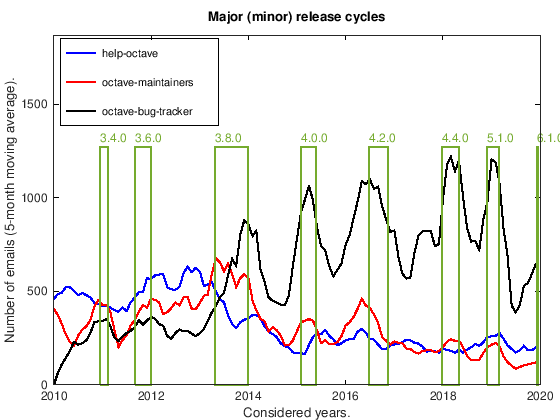

In [11]:
plot (x_ticks(idx), activity_smooth(1,idx), "b", ...
      x_ticks(idx), activity_smooth(2,idx), "r", ...
      x_ticks(idx), activity_smooth(3,idx), "k");
datetick ("x");
set (gca (), "FontSize", 12);
legend (lists, "location", "northwest");
xlabel ("Considered years.");
ylabel ("Number of emails (5-month moving average).");
title ("Major (minor) release cycles");
ylim ([0 max_val + 600])
green = [0.46 0.67 0.18];
for i = 1:R
  rectangle ("Position", releases(i,:), "EdgeColor", green, "LineWidth", 4);
  text (releases(i,1), max_val + 50, release_labels{i}, ...
        "Color", green, "FontSize", 12);
endfor

## Final remarks

A selection of utilized functions and links to the Manual:

* `arrayfun()`
  https://octave.org/doc/v5.1.0/Function-Application.html
* `legend()`, `plot()`
  https://octave.org/doc/v5.1.0/Two_002dDimensional-Plots.html and
  https://octave.org/doc/v5.1.0/Graphics-Object-Properties.html
* `set(0, ...)`
  https://octave.org/doc/v5.1.0/Managing-Default-Properties.html
* `urlread()`
  https://octave.org/doc/v5.1.0/Networking-Utilities.html
* `load()`, `save()`
  https://octave.org/doc/v5.1.0/Simple-File-I_002fO.html
* `movmean()`
  https://octave.org/doc/v5.1.0/Statistics.html
* `tic .. toc`, `datenum()`, `datetick()`, `datevec()`, `now()`
  https://octave.org/doc/v5.1.0/Timing-Utilities.html